In [1]:
from time import time
import shutil
import random

import pandas as pd
import cv2
import matplotlib.pyplot as plt
from functools import lru_cache
import numpy as np
from scipy import ndimage, stats
from itertools import islice

In [2]:
# Optical Flow Based
def fix_perspective(im, debugging=False):
    h, w = im.shape
    assert (w, h) == (640, 160) # this is tuned for a very specific crop and dashcam position
    left = 60 # left-right adjustment
    top = 5
    bottom = 30
    if debugging:
        src_rect = np.array([
            [245, originy+top],   [370, originy+top],
            [0, 125],   [600, 100]],
            dtype = "float32")
        dst_rect = np.array([
            [80-left, 0],    [330-left, 0],
            [108-left, 840],  [320-left, 800]],
            dtype = "float32")
        M = cv2.getPerspectiveTransform(src_rect, dst_rect)
        print(repr(M))
    else:
        M = np.array(
           [[-5.79976346e+00, -2.25571424e+01,  1.92672659e+03],
            [-1.81898940e-14, -1.56260338e+02,  3.90650844e+03],
            [ 5.42171076e-05, -1.56819369e-01,  1.00000000e+00]])
    dst = cv2.warpPerspective(im,M,(300,840-bottom))
    if debugging:
        plt.rcParams['figure.figsize'] = [20, 12]
        plt.imshow(im)
        plt.show()
        plt.imshow(dst)
        plt.show()
    return dst

originy=None
def crop(image, bottom=100, top=220):
    # take of top and bottom
    global originy
    originy = image.shape[0] / 2 - top
    return image[top:image.shape[0] - bottom,:]

def mutating_base_calcs(df, n):
    df['dx'] = df.x2 - df.x1 + 0.00001
    df['dy'] = (df.y2 - df.y1)/n
    df['Vf_slope'] = df.dy/df.dx
    df['|Vf|'] = np.sqrt(df.dx**2 + df.dy**2)

    df['right_direction'] = (df.y2>df.y1) & (abs(df.Vf_slope) > 3) # down and steep
    df['good'] = df['right_direction']

def analyze_lk_optical_flow_dfs(dfs):
    xs = []
    def analyze_df(df):
        nonlocal xs
        # absurd
        #df['good'] = df['good'] & (df['|Vf|'] > 2.5)
        df['good'] = df['good'] & (df['|Vf|'] < (35/.45)) #25 is data set max, .45 coverts from Vf to velocity
        
        if sum(df['good']==True) == 0:
            xs += [np.nan, np.nan]
        else:
            with np.errstate(divide='ignore',invalid='ignore'):
                df.loc[df['good'],'z'] = stats.zscore(df.loc[df['good'],'|Vf|'])
            df.loc[df['good']==False,'z'] = 100.0
            df['good'] = df['good'] & (df['z'] < 1.7)

            if len(df) != 0:
                # filter out noisy "small" flow vectors
                Vf_max_good = df[df['good']==True]['|Vf|'].max()
                df['good'] = df['good'] & (df['|Vf|'] > Vf_max_good * 0.25)
            xs.append(df.loc[df['good'],'|Vf|'].mean())
            xs.append(df.loc[df['good'],'|Vf|'].std())
        xs.append(df['dy'].mean())
    overall = 0
    for n, df in enumerate(dfs):
        global N
        N = n + 1
        mutating_base_calcs(df,N)
        analyze_df(df)
        
        overall += df.loc[df['good'],'|Vf|'].mean()/(len(dfs)+1)
    
    stacked_df = pd.concat(dfs, ignore_index=True)
    analyze_df(stacked_df)
    overall += stacked_df.loc[stacked_df['good'],'|Vf|'].mean()/(len(dfs)+1)
    
    xs.append(overall)

    # 0 1 2 #n=1
    # 3 4 5 #n=2
    # 6 7 8 #n=3
    # 9 10 11 #stacked
    # 12 #overall
    return xs

def via_lk_optical_flow_multi(frame, count=3):
    frame['optical_flow'] = []
    dfs = []
    for i in range(1, count+1):
        dfs.append(optical_flow(frame['_'], frame[str(i)], frame))
    return analyze_lk_optical_flow_dfs(dfs)

def debug_optical(df,img):
    img = image_next.copy()
    # we lose old arrow debugging with the df approach, sorry
    #         if right_direction:
    #             color=255
    #             df.loc[i,'good'] = True
    #         else:
    #             color=130
    #             df.loc[i,'good'] = False

    #         if debugging:
    #             img = cv2.arrowedLine(img,(int(x1),int(y1)),(int(x2),int(y2)), color, tipLength=.3)
    #             img = cv2.circle(img,(int(x1),int(y1)),2,color, -1)
    if len(df) == 0:
        print("no useful points")
    else:
        display(df.sort_values(by='|Vf|'))       
        bins = list(range(0,101,10))
        plt.rcParams['figure.figsize'] = [20, 5]
        df['|Vf|'].hist(bins=bins)
        df[df['good']==True]['|Vf|'].hist(bins=bins)
        plt.show()

    plt.rcParams['figure.figsize'] = [20, 12]
    plt.imshow(img)
    plt.show()

# params for ShiTomasi corner detection
feature_params = dict(
    maxCorners = 100,
    qualityLevel = 0.007,
    minDistance = 20,
    blockSize = 9,
    #useHarrisDetector = True,
    )

# Parameters for lucas kanade optical flow
lk_params = dict(
    winSize  = (15,15),
    maxLevel = 1,
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )

def optical_flow(image, image_next, frame, debugging=False):
    p0 = cv2.goodFeaturesToTrack(image, mask=None, **feature_params)
    p1, st, err = cv2.calcOpticalFlowPyrLK(image, image_next, p0, None, **lk_params)
    
    points = []
    for new, old in zip(p1[st==1],p0[st==1]):
        x1, y1 = old.ravel()
        x2, y2 = new.ravel()
        points.append((x1,x2,y1,y2))
    
    df = pd.DataFrame(data=points, columns=('x1','x2','y1','y2'))
    if debugging:
        debug_optical(df,img)

    frame['optical_flow'].append(df)
    return df


In [3]:
# Process frames
def lookahead(frames, count=3):
    # add "lookahead" in keys '1', '2', ...
    # repeats at the end to keep length len
    fs = list()
    def _updated_f():
        f = fs.pop(0)
        f.update({str(n+1):f['_'] for n, f in enumerate(fs)})
        return f 
        
    for f in frames:
        fs.append(f)
        if len(fs) > count:
            yield _updated_f()

    for _ in range(count):
        fs.append(f)
        yield _updated_f()
        
def print_frame_keys(frames):
    for f in frames:
        print(repr(list(f.keys())))
        yield f

def view_frames(frames):
    for f in frames:
        for k in f.keys():
            try:
                cv2.imshow(k,f[k])
            except:
                pass
        try:
            cv2.waitKey(0)
        except KeyboardInterrupt:
            cv2.destroyAllWindows()
            print("Stopping early, KeyboardInterrupt")
            return
        yield f
    cv2.destroyAllWindows()

def persist_raw_optical_flow(frames):
    import os
    path = f'./data/{int(time())}'
    os.makedirs(path)
    for i, f in enumerate(frames):
        for j, df in enumerate(f['optical_flow']):
            df: pd.DataFrame
            df.to_pickle(os.path.join(path,f'{i}_{j}.pkl'))
        yield f

class FeatureExtractor():
    def __init__(self):
        self._steps = []

    def add_step(self, step):
        """step(frames_iterator) yields-> [frame,frame,...]; you can filter or gather frames"""
        if callable(step):
            self._steps.append(step)

    def add_processor(self, processor):
        """processor(img) returns-> img; frame['_'] is mutated"""
        def _step(frames):
            for f in frames:
                f['_'] = processor(f['_'])
                yield f
        self.add_step(_step)

    def add_analyzer(self, analyzer):
        """analyzer(frame) returns-> [x1,x2,...]; frame['_'] is forwarded untouched, features are collected"""
        def _step(frames):
            for f in frames:
                f['xs'] += analyzer(f)
                yield f
        self.add_step(_step)
        
    def extract_features(self, file='../data/train.mp4'):
        frames = self._frames(file)
        pipeline = self._make_pipe(frames)
        self._start = time()
        self._last = self._start
        X = []
        i = 0
        for i, f in enumerate(pipeline):
            X.append(f['xs'])
            self._pprogress(i)
        self._pprogress(i,True)
        return X

    def _frames(self, file):
        vidcap = cv2.VideoCapture(file)
        while True:
            success, image = vidcap.read()
            if success:
                yield {'orig': image, '_': image, 'xs':[]}
            else:
                return

    def _make_pipe(self, frames):
        pipeline = frames
        for s in self._steps:
            pipeline = s(pipeline)
        return pipeline

    def _pprogress(self, count, force=False):
        if force or time()-self._last>30:
            self._last = time()
            print(f"{count+1} processed in {(time()-self._start)/60:2.1f} minutes")


In [4]:
fe = FeatureExtractor()

#fe.add_step(lambda g: islice(g, 17500, 20400, 1)) # limit frames (start, stop, step)
#fe.add_step(lambda g: islice(g, 400, 420, 1)) # limit frames (start, stop, step)

fe.add_processor(lambda img: crop(img, bottom=100, top=220))
fe.add_processor(lambda img: cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
fe.add_processor(fix_perspective)
fe.add_processor(lambda img: cv2.GaussianBlur(img,(7,7),0))

fe.add_step(lambda frames: lookahead(frames, count=3))

fe.add_analyzer(via_lk_optical_flow_multi)

fe.add_step(persist_raw_optical_flow)
#fe.add_step(print_frame_keys)
#fe.add_step(view_frames)

xs = fe.extract_features('../data/train.mp4')

755 processed in 0.5 minutes
1457 processed in 1.0 minutes
2153 processed in 1.5 minutes
2856 processed in 2.0 minutes
3558 processed in 2.5 minutes
4259 processed in 3.0 minutes
4955 processed in 3.5 minutes
5652 processed in 4.0 minutes
6354 processed in 4.5 minutes
7046 processed in 5.0 minutes
7746 processed in 5.5 minutes
8371 processed in 6.0 minutes
9014 processed in 6.5 minutes
9691 processed in 7.0 minutes
10367 processed in 7.5 minutes
11049 processed in 8.0 minutes
11740 processed in 8.5 minutes
12388 processed in 9.0 minutes
13066 processed in 9.5 minutes
13761 processed in 10.0 minutes
14435 processed in 10.5 minutes
15104 processed in 11.0 minutes
15759 processed in 11.5 minutes
16464 processed in 12.0 minutes
17146 processed in 12.5 minutes
17850 processed in 13.0 minutes
18547 processed in 13.5 minutes
19233 processed in 14.0 minutes
19928 processed in 14.5 minutes
20400 processed in 14.8 minutes


In [385]:
y = pd.read_csv('../data/train.txt', header=None)
X = pd.DataFrame(xs)
X.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,20301.000000,20199.000000,20400.000000,20171.000000,20038.000000,20399.000000,19960.000000,19799.000000,20399.000000,20300.000000,20277.000000,20400.000000,19907.000000
mean,22.052734,5.525136,4.799234,21.724671,5.542001,2.844092,21.518410,5.687407,2.333646,21.417903,5.424170,3.357223,21.750685
std,16.133754,4.117217,9.669150,15.673859,4.248105,7.581492,15.271258,4.529610,6.865346,15.371821,3.901604,7.012366,15.284451
min,0.004153,0.002088,-116.187047,0.001527,0.000472,-126.458439,0.002043,0.000354,-99.169061,0.002558,0.001149,-114.883626,0.032415
25%,8.168556,2.425897,-0.238537,8.194919,2.224346,-0.818561,8.350239,2.147118,-0.985925,8.177106,2.313584,-0.352002,8.562533
50%,17.904147,4.502413,3.863911,17.847354,4.385355,2.245137,17.948092,4.433294,1.793814,17.581195,4.558648,2.688383,18.125114
75%,35.406030,7.734051,9.793322,35.071106,8.178047,6.362307,34.640009,8.480785,5.344351,34.780746,8.106215,6.777629,35.137876
max,73.891515,38.534682,83.617086,77.726476,34.490408,52.578316,77.525239,39.584484,48.778914,73.523423,38.534682,49.815615,66.597995


In [386]:
def fill_nan(df):
    df.fillna(df.rolling(10,min_periods=1,win_type='nuttall').mean(), inplace=True)
    df.fillna(method='pad', inplace=True)
fill_nan(X)
X.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000
mean,22.066198,5.513674,4.799234,21.656291,5.524715,2.843919,21.411911,5.655717,2.333524,21.403003,5.422936,3.357223,21.610619
std,16.152478,4.128620,9.669150,15.670288,4.262156,7.581347,15.276184,4.540334,6.865200,15.364656,3.911392,7.012366,15.281607
min,0.004153,0.002088,-116.187047,0.001527,0.000472,-126.458439,0.002043,0.000354,-99.169061,0.002558,0.001149,-114.883626,0.032415
25%,8.169277,2.401677,-0.238537,8.151503,2.192082,-0.818544,8.282148,2.105629,-0.985770,8.178301,2.304831,-0.352002,8.444247
50%,17.946375,4.494863,3.863911,17.789860,4.370287,2.245015,17.783813,4.411172,1.793400,17.557080,4.559128,2.688383,18.001417
75%,35.427962,7.720771,9.793322,34.956317,8.172743,6.361703,34.514401,8.444095,5.344049,34.765557,8.101147,6.777629,34.884776
max,73.891515,38.534682,83.617086,77.726476,34.490408,52.578316,77.525239,39.584484,48.778914,73.523423,38.534682,49.815615,66.597995


In [387]:
Xy = X.copy()
Xy['y'] = y.copy()

# smooth based on distribution of acceleration in training set
idea use kalman filter based 

In [388]:
# tune a kalman filter
from pykalman import KalmanFilter
em_vars = [
     #'transition_covariance',
     'observation_covariance',
     'initial_state_mean', 'initial_state_covariance']

T = np.array([[.0009]]) # smaller is more resistance to acceleration
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, transition_covariance=T)
#kf = kf.em(Xy2.loc[Xy2_train_ix,'y'].values, n_iter=0, em_vars=em_vars)

In [479]:
# mean(|Vf|) stdev(|Vf|) mean(dy)
# 0  1  2   #n=1
# 3  4  5   #n=2
# 6  7  8   #n=3
# 9  10 11  #stacked
# 12        #overall

y_pred_col = 12
velocity_per_vf = .577

def filter_scaled_cloud_for_stop(series):
    def _(span):
        height_thresh = 2.6
        fraction_under_thresh_required = 1/6.8
        return sum((span < height_thresh)) > len(span)*fraction_under_thresh_required
    stopped_mask = series.rolling(160,center=True, min_periods=1).apply(_)
    going  = series * (stopped_mask==False)
    
    return (1+np.log(series))*stopped_mask + going

def kf_and_scale(df):
    df['y_pred_scaled'] = df[y_pred_col] * velocity_per_vf
    df['y_pred_scaled'] = filter_scaled_cloud_for_stop(df['y_pred_scaled'])
    df[df['y_pred_scaled'] < 0] = 0
    df['y_pred_kf'] = kf.smooth(df['y_pred_scaled'].values)[0]
    

kf_and_scale(Xy)

/home/y2k/.local/share/virtualenvs/y2kspeed-NWwxFr2U/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [480]:
Xy.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,y,y_pred_scaled,y_pred_kf
count,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000
mean,22.054510,5.510056,4.816465,21.649723,5.522238,2.860821,21.398350,5.653623,2.349796,21.391154,5.420208,3.374030,21.603840,12.182708,12.260083,12.258805
std,16.166454,4.133330,9.658145,15.679255,4.265310,7.572072,15.285026,4.542900,6.856809,15.375927,3.915102,7.001417,15.291100,8.207453,9.000353,8.337263
min,0.000000,0.000000,-116.187047,0.000000,0.000000,-126.458439,0.000000,0.000000,-99.169061,0.000000,0.000000,-114.883626,0.000000,0.000000,0.000000,0.145065
25%,8.166345,2.401677,0.000000,8.151503,2.192082,-0.728581,8.277906,2.105629,-0.917612,8.177106,2.304831,-0.173414,8.444247,5.011801,4.160263,4.931456
50%,17.943905,4.494863,3.863151,17.789860,4.370287,2.245015,17.766760,4.411172,1.793400,17.550700,4.559128,2.688383,18.001417,10.600500,10.278218,10.720536
75%,35.427962,7.720771,9.793322,34.956317,8.172743,6.361703,34.507342,8.444095,5.344049,34.764430,8.101147,6.777629,34.884776,21.324059,20.116500,21.051745
max,73.891515,38.534682,83.617086,77.726476,34.490408,52.578316,77.525239,39.584484,48.778914,73.523423,38.534682,49.815615,66.597995,28.130404,38.427043,27.847267


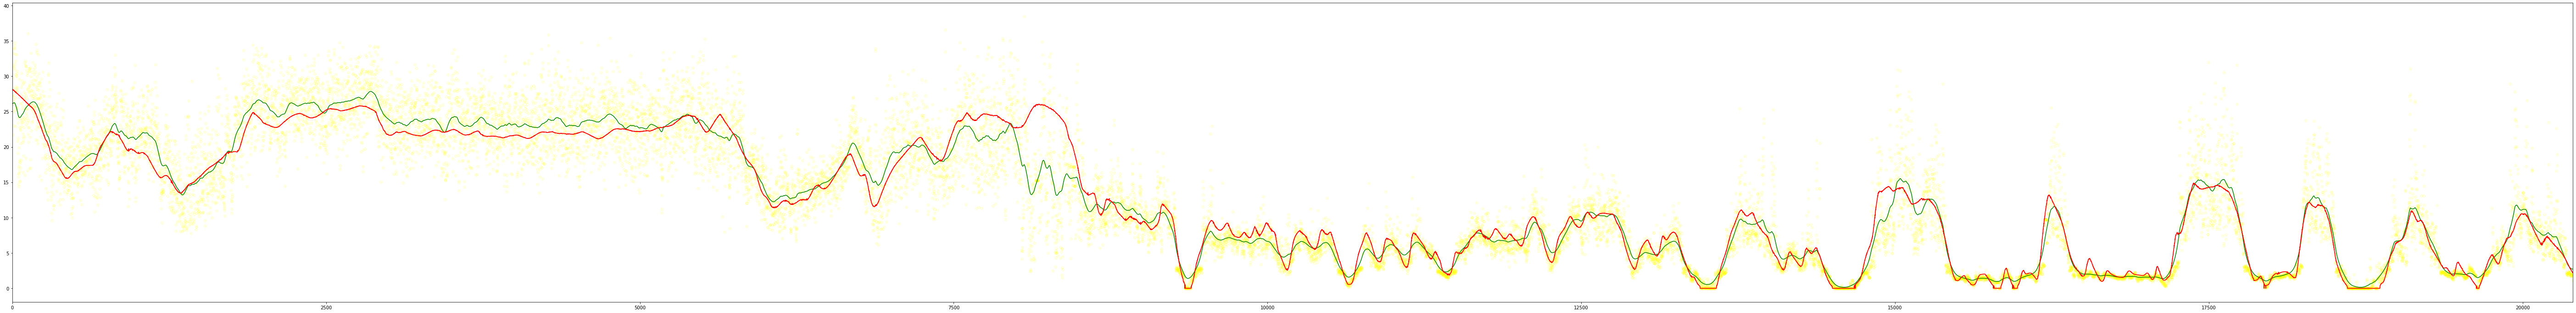

In [481]:
plt.rcParams['figure.figsize'] = [100, 12]
plt.gca().set_xlim((0,len(Xy)))

def plot(df, ix_mask, column, **kwargs):
    try:
        if ix_mask is None:
            df = df.loc[:,column]
        else:
            df = df.loc[ix_mask, column]
        plt.plot(df.index, df.values, **kwargs)
    except KeyError:
        print(f"Skipping {column}")
    
plot(Xy, None, 'y_pred_scaled', marker='o', linewidth=0.0, color='yellow', alpha=.1)
plot(Xy, None, 'y_pred_kf', marker='', linewidth=1.5, color='green')
plot(Xy, None, 'y', marker='', linewidth=1.7, color='red')

In [482]:
err = ((Xy['y'] - Xy['y_pred_kf'])**2).mean()
print(f"MSE\n{err:0.1f}", end='\t') # 10.3 was best, gaussian made it 7.2, 3.4 with tweaks to Flow Vector filtering

MSE
3.4	

# save out

In [483]:
#xs_test = fe.extract_features(file='../data/test.mp4')

In [484]:
X_test = pd.DataFrame(xs_test)
fill_nan(X_test)
kf_and_scale(X_test)

Skipping fixed


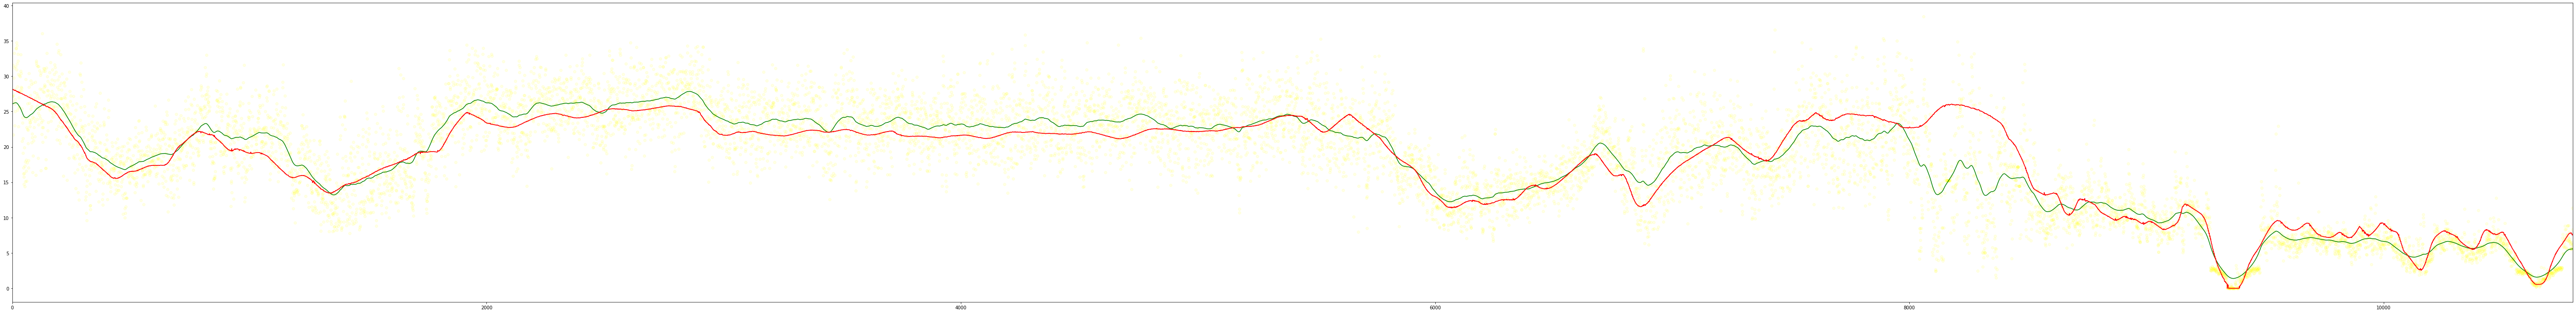

Skipping fixed


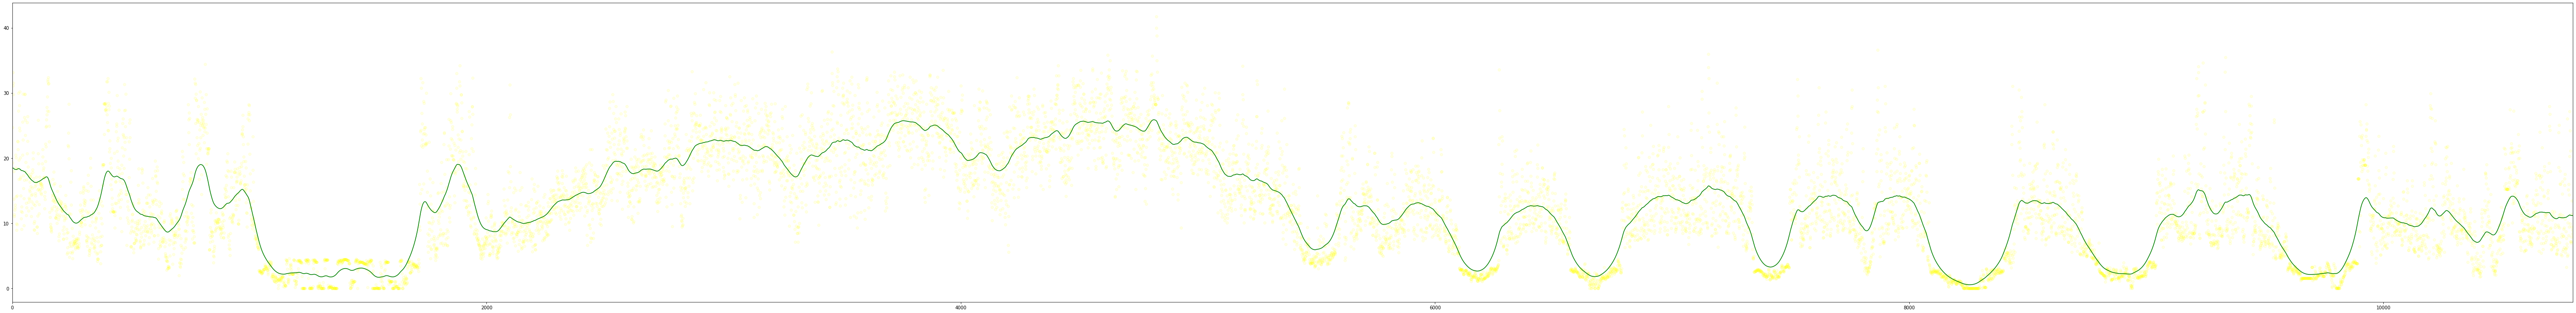

In [485]:
plt.gca().set_xlim((0,len(X_test)))
plot(Xy, None, 'y_pred_scaled', marker='o', linewidth=0.0, color='yellow', alpha=.1)
plot(Xy, None, 'y_pred_kf', marker='', linewidth=1.5, color='green')
plot(Xy, None, 'y', marker='', linewidth=1.7, color='red')
plot(Xy, None, 'fixed', marker='', linewidth=1.5, color='blue')
plt.show()
plt.gca().set_xlim((0,len(X_test)))
plot(X_test, None, 'y_pred_scaled', marker='o', linewidth=0.0, color='yellow', alpha=.1)
plot(X_test, None, 'y_pred_kf', marker='', linewidth=1.5, color='green')
plot(X_test, None, 'fixed', marker='', linewidth=1.5, color='blue')

In [486]:
X_test.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,y_pred_scaled,y_pred_kf
count,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000,10798.000000
mean,23.814817,6.616052,9.184892,23.811050,6.780825,5.399479,23.583897,6.903749,3.747345,23.308223,6.505929,6.232921,23.597888,12.813006,12.811298
std,15.047621,4.868014,12.895434,14.980860,5.170993,9.302275,14.919976,5.575664,7.689560,14.430756,4.648420,9.027256,13.887177,8.225403,6.665903
min,0.000000,0.000000,-366.180580,0.000000,0.000000,-175.058533,0.000000,0.000000,-112.619484,0.000000,0.000000,-217.952866,0.000000,0.000000,0.547758
25%,12.108032,3.046966,1.378500,12.271129,2.866210,0.195535,12.467513,2.763763,-0.124795,12.218622,2.945760,0.922370,13.010878,6.284563,8.825070
50%,21.557545,5.230291,8.501210,21.399757,5.179055,4.844150,21.120867,5.243353,3.217403,21.049112,5.097870,5.682636,21.931226,11.797114,12.528446
75%,34.553942,9.569233,16.128898,34.268574,10.192999,9.908307,33.392346,10.085771,7.244462,33.692234,9.807812,10.747890,33.823106,18.893255,17.745415
max,77.399306,37.939528,137.374756,77.758518,38.907740,78.509430,77.712470,37.984232,70.023131,75.714166,32.926427,74.981662,72.308767,41.722158,25.880454
